# Trabalho 1 - MO651
### Professora Esther Columbini
#### Tito Barbosa Rezende RA 025327
#### João Paulo
#### Elcio Pereira de Souza Junior RA 262952

### Pré-requisitos

In [22]:
%pip install matplotlib
%pip install numpy
%pip install opencv-python

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [96]:
import sys, time
sys.path.insert(0, '../src')
from robot import Robot
import utils
import matplotlib.pyplot as plt
import numpy as np
import vrep
import math
import multiprocessing
import random
from datetime import datetime

## Definindo nosso objeto Robô e testando conexão e API

In [24]:
robot = Robot()

Connected to remoteApi server.
 Pioneer_p3dx_ultrasonicSensor1 connected.
 Pioneer_p3dx_ultrasonicSensor2 connected.
 Pioneer_p3dx_ultrasonicSensor3 connected.
 Pioneer_p3dx_ultrasonicSensor4 connected.
 Pioneer_p3dx_ultrasonicSensor5 connected.
 Pioneer_p3dx_ultrasonicSensor6 connected.
 Pioneer_p3dx_ultrasonicSensor7 connected.
 Pioneer_p3dx_ultrasonicSensor8 connected.
 Pioneer_p3dx_ultrasonicSensor9 connected.
 Pioneer_p3dx_ultrasonicSensor10 connected.
 Pioneer_p3dx_ultrasonicSensor11 connected.
 Pioneer_p3dx_ultrasonicSensor12 connected.
 Pioneer_p3dx_ultrasonicSensor13 connected.
 Pioneer_p3dx_ultrasonicSensor14 connected.
 Pioneer_p3dx_ultrasonicSensor15 connected.
 Pioneer_p3dx_ultrasonicSensor16 connected.
 Vision sensor connected.
 Laser connected.
 Left motor connected.
 Right motor connected.
 Robot connected.


Testando os sensores

In [25]:
print ('Sensores Ultrassônicos')
print (robot.read_ultrassonic_sensors())

Sensores Ultrassônicos
[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 0.5417293310165405, 0.4214608371257782, 0.40877825021743774, 5.0, 5.0, 5.0, 5.0]


In [26]:
print ('Laser')
print (robot.read_laser())

Laser
[-0.6148700714111328, -1.0649861097335815, 0.0629999190568924, -0.6147826910018921, -1.0801011323928833, 0.0629999190568924, -0.6113798022270203, -1.0896357297897339, 0.0629999190568924, -0.6059932708740234, -1.0957521200180054, 0.0629999190568924, -0.60845947265625, -1.1163465976715088, 0.0629999190568924, -2.2540316581726074, -4.196628570556641, 0.06299970299005508, -2.215325355529785, -4.186038970947266, 0.06299970299005508, -2.1861484050750732, -4.192997932434082, 0.06299970299005508, -2.148533344268799, -4.183328628540039, 0.06299970299005508, -2.120206356048584, -4.191320896148682, 0.06299969553947449, -2.0836005210876465, -4.182537078857422, 0.06299969553947449, -2.0561203956604004, -4.191682815551758, 0.06299969553947449, -2.0204453468322754, -4.183749675750732, 0.06299969553947449, -1.993703842163086, -4.1939616203308105, 0.06299968808889389, -1.9588885307312012, -4.186850547790527, 0.06299968808889389, -1.924533724784851, -4.180117130279541, 0.06299968808889389, -1.8987

Testando Visão do Robo

In [27]:
def take_picture():
    vision_snapshot = robot.read_vision_sensor()
    resolution = vision_snapshot[0]
    img = vision_snapshot[1]
    rbgimage = utils.vrep2array(img, resolution)
    plt.imshow(rbgimage)
    plt.show()

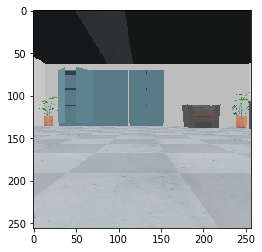

In [28]:
take_picture()

Testando a posição global do Robô

In [29]:
print('Posição')
print(robot.get_current_position())
print('Orientação')
print(robot.get_current_orientation())

Posição
[-2.0622246265411377, -0.8277751803398132, 0.13868147134780884]
Orientação
[-8.090616756817326e-05, -0.002014217199757695, -0.004496862180531025]


Testando atuadores (movimentação)

Velocidade em m/s

Velocidade angular em rad/s

(retire os comentários para testar e movimentar o robo)

In [30]:
robot.set_left_velocity(1)

In [31]:
robot.stop()

In [32]:
robot.set_right_velocity(2)
robot.set_left_velocity(2)

In [33]:
robot.set_right_velocity(2)

In [34]:
#robot.stop()

In [35]:
robot.set_velocity(1,1) #V, W

In [36]:
robot.stop()

## Modelo Kinemático

### Sensor Laser

In [37]:
class Laser_sensor:
    def __init__(self,robot):
        self.robot = robot

    def update_robot_frame_reading(self):
        laser_flatten_readings = np.array(self.robot.read_laser())
        laser_readings = laser_flatten_readings.reshape((len(laser_flatten_readings)//3, 3))
        self.laser_x = laser_readings[:,0]
        self.laser_y = laser_readings[:,1]
laser_sensor = Laser_sensor(robot)
laser_sensor.update_robot_frame_reading()

In [38]:
def plot_lase_robot_frame():
    fig, ax = plt.subplots()
    #posição dos feixes laser
    ax.scatter(laser_sensor.laser_x, laser_sensor.laser_y, 3, c='g', marker='o')
    #posição do centro do robo
    ax.scatter(0, 0, 40, c='b', marker='o')
    plt.show()

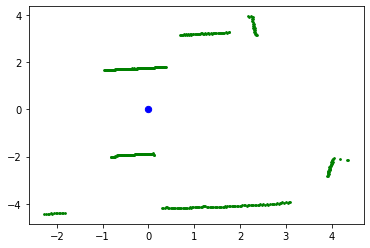

In [39]:
plot_lase_robot_frame()

In [40]:
# Vamos mudar a posição do robo e ler novamente
robot.set_left_velocity(-1)
robot.set_right_velocity(2)
time.sleep(5)
robot.stop()

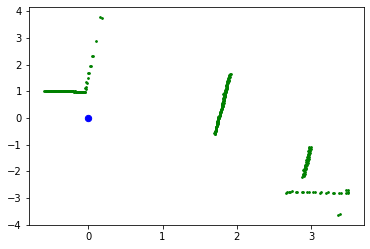

In [41]:
laser_sensor.update_robot_frame_reading()
plot_lase_robot_frame()

### Sensor Ultrassonico

Para obter a leitura correta dos sensores de proximidade, precisamos transformar a leitura do sensor em um ponto X,Y em relação ao frame do robo.


In [42]:
class Us_sensor:
    def __init__(self,robot):
        orientation_angles = np.array([90,50,30,10,-10,-30,-50,-90,-90,-130,-150,-170,170,150,130,90])
        orientation_rad = np.radians(orientation_angles)
        self.data = {
        "prefix" : "Pioneer_p3dx_ultrasonicSensor",
        "ids" : np.arange(1,17,1), "handles" : np.zeros(16, dtype=int), 
        "positions" :  np.zeros((16,3),dtype=float),
        "angles_deg": orientation_angles,
        "angles_rad": orientation_rad,
        "raw_reading": np.zeros(16),
        "robot_frame_reading": np.zeros((16,2),dtype=float)
        }
        self.robot = robot
        
        for i,sensor_i in enumerate(self.data['ids']):
            ret,handle = vrep.simxGetObjectHandle(self.robot.clientID, self.data['prefix'] + str(sensor_i), vrep.simx_opmode_oneshot_wait)
            self.data['handles'][i] = handle
            ret, pos = vrep.simxGetObjectPosition(self.robot.clientID, handle, self.robot.robot_handle, vrep.simx_opmode_oneshot_wait)
            #ret, ang = vrep.simxGetObjectOrientation(robot.clientID, handle, robot.robot_handle, vrep.simx_opmode_oneshot_wait)
            self.data['positions'][i,:] = pos
            #ultrassonic_sensors[sensor_i,4:7] = ang
    
    def update_raw_reading(self):
        self.data["raw_reading"] = np.array(self.robot.read_ultrassonic_sensors())
    
    def update_robot_frame_reading(self):
        self.update_raw_reading()
        for i, proximity in enumerate(us_sensors.data["raw_reading"]):
            if proximity == 5 or proximity < 0.1:
                self.data["robot_frame_reading"][i] = np.zeros(2)
            else:
                self.data["robot_frame_reading"][i] = self.proximity_robot_frame(i+1,proximity).flatten()
                
        #toRobotFrame = lambda sensorId,proximity: self.proximity_robot_frame(sensorId,proximity)
        #self.data["robot_frame_reading"] = toRobotFrame(range(1,17,1),us_sensors.data["raw_reading"])
    
    #Calcula o ponto no frame do robo, referente a leitura de cada sensor de proximidade
    def proximity_robot_frame(self,sensorId, proximity):
        index = sensorId -1
        angulars = self.data["angles_rad"][index]
        #Matriz de rotação
        rot_matrix = np.array([[math.cos(angulars),-math.sin(angulars)],[math.sin(angulars),math.cos(angulars)]])
        #Rotacionando a leitura
        distXY = np.dot(rot_matrix , np.array([[proximity],[0]]))
        #Matriz de translação
        posicao_sensor_x = self.data["positions"][index][0]
        posicao_sensor_y = self.data["positions"][index][1]
        transXY=np.array([[distXY[0][0]+posicao_sensor_x],[distXY[1][0]+posicao_sensor_y]])
        return transXY

us_sensors = Us_sensor(robot)

As leituras brutas do sensor ultrassonico seriam

In [43]:
us_sensors.update_raw_reading()
us_sensors.data["raw_reading"]

array([0.84485954, 5.        , 5.        , 5.        , 5.        ,
       5.        , 5.        , 5.        , 5.        , 5.        ,
       5.        , 5.        , 5.        , 5.        , 5.        ,
       0.84485966])

Enquanto que as leituras dos sensores ultrassonicos rotacionadas e trasladadas para o frame do robo seriam

In [44]:
us_sensors.update_robot_frame_reading()
us_sensors.data["robot_frame_reading"]

array([[ 0.10637701,  0.98305827],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [-0.11032319,  0.98305839]])

Localizando então a posição dos sensores em relação ao frame do robo, em vermelho, e os pontos resultados de leitura

In [45]:
def plot_us_robot_frame():
    fig, ax = plt.subplots()
    #posição dos sensores US
    ax.scatter(us_sensors.data['positions'][:,0], us_sensors.data['positions'][:,1], 10, c='r', marker='o')
    #posição do centro do robo
    ax.scatter(0, 0, 40, c='b', marker='o')
    #posição dos pontos lidos pelo sensor ultrassonico
    ax.scatter(us_sensors.data['robot_frame_reading'][:,0], us_sensors.data['robot_frame_reading'][:,1], 10, c='black', marker='.')

    plt.show()

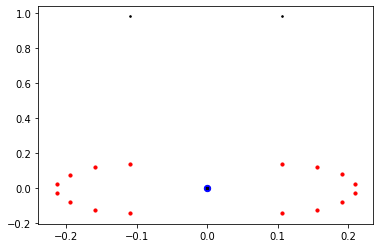

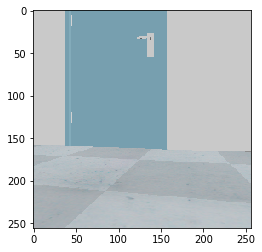

In [46]:
us_sensors.update_robot_frame_reading()
plot_us_robot_frame()
take_picture()

In [47]:
#vamos mudar a posição do robo e repetir a leitura
robot.set_left_velocity(3)
robot.set_right_velocity(2)
time.sleep(5)
robot.stop()

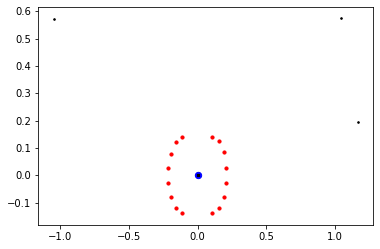

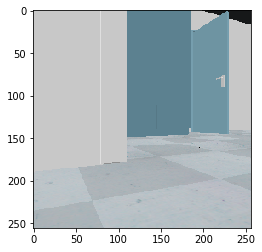

In [48]:
us_sensors.update_robot_frame_reading()
plot_us_robot_frame()
take_picture()

### Vamos juntar ambas leituras e comparar os pontos

In [49]:
def plot_robot_frame():
    fig, ax = plt.subplots()
    #posição dos sensores US
    ax.scatter(us_sensors.data['positions'][:,0], us_sensors.data['positions'][:,1], 10, c='r', marker='o')
    #posição do centro do robo
    ax.scatter(0, 0, 40, c='b', marker='o')
    #posição dos pontos lidos pelo sensor ultrassonico
    ax.scatter(us_sensors.data['robot_frame_reading'][:,0], us_sensors.data['robot_frame_reading'][:,1], 10, c='black', marker='.')
    #posição dos feixes laser
    ax.scatter(laser_sensor.laser_x, laser_sensor.laser_y, 3, c='g', marker='.')
    
    plt.show()

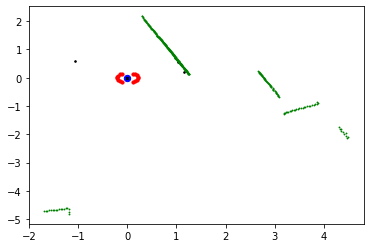

In [50]:
us_sensors.update_robot_frame_reading()
laser_sensor.update_robot_frame_reading()
plot_robot_frame()

In [51]:
robot.set_right_velocity(-3)
robot.set_left_velocity(-3)
time.sleep(5)
robot.stop()

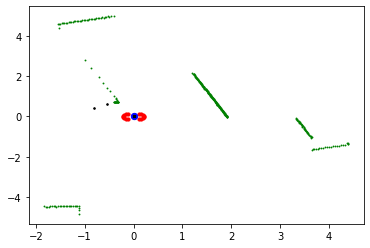

In [52]:
us_sensors.update_robot_frame_reading()
laser_sensor.update_robot_frame_reading()
plot_robot_frame()

Função para transformar os pontos para a referencia global

In [95]:
def toGlobal(robot_x, robot_y,robot_ang, Point_xr, Point_yr):
    T_trans = np.array([[1,0,robot_x],[0,1,robot_y],[0,0,1]])
    T_rot = np.array([[math.cos(robot_ang),-math.sin(robot_ang),0],[math.sin(robot_ang),math.cos(robot_ang),0],[0,0,1]])
    T = np.dot(T_trans,T_rot)
    res = np.dot(T, np.array([Point_xr,Point_yr,1]))
    return res[0],res[1]

## Modelo cinematico direto

Dado o movimento do robo, como determinar sua posição e orientação no frame global?

In [170]:
# Esse código precisa de revisao
class Kinematic_model:
    def __init__(self,robot):
        self.robot = robot
        
        #Handles dos motores
        ret1, self.motorLeft = vrep.simxGetObjectHandle(self.robot.clientID, "Pioneer_p3dx_leftMotor", vrep.simx_opmode_oneshot_wait)
        ret2, self.motorRight = vrep.simxGetObjectHandle(self.robot.clientID, "Pioneer_p3dx_rightMotor", vrep.simx_opmode_oneshot_wait)
        
        #Calcula distancia de eixo
        res, left_handle = vrep.simxGetObjectHandle(robot.clientID, "Pioneer_p3dx_leftMotor", vrep.simx_opmode_oneshot_wait)
        ret, lpos = vrep.simxGetObjectPosition(robot.clientID, left_handle, robot.robot_handle, vrep.simx_opmode_oneshot_wait)
        
        res, right_handle = vrep.simxGetObjectHandle(robot.clientID, "Pioneer_p3dx_rightMotor", vrep.simx_opmode_oneshot_wait)
        ret, rpos = vrep.simxGetObjectPosition(robot.clientID, right_handle, robot.robot_handle, vrep.simx_opmode_oneshot_wait)
        
        self.l = (abs(lpos[1]) + abs(rpos[1]))/2
        #self.l2 = lpos[0] #Que é igual ao rpos[0] para nosso robo
        
        #Ao ser criado, coleta a referencia de zero do robo
        pos = self.robot.get_current_position()
        self.initial_pos_x = pos[0]
        self.initial_pos_y = pos[1]
        orientation = self.robot.get_current_orientation()
        self.initial_orientation = orientation[2]

        #Alem de mantermos a pose inicial, manteremos a pose atualizada do robo
        self.enc_global_x = self.initial_pos_x
        self.enc_global_y = self.initial_pos_y
        self.enc_Theta = self.initial_orientation
        
        self.time_global_x = self.initial_pos_x
        self.time_global_y = self.initial_pos_y
        self.time_Theta = self.initial_orientation
        
        #Lista de pontos para o caminho do robo
        self.enc_path = []
        self.time_path = []
        self.true_path = []
        self.update_paths()
        
        #inicializando a posição dos encoders
        self.jL = self.current_encoder_left()
        self.jR = self.current_encoder_right()
        
        #intervalo entre cada calculo
        self.compute_interval = 0.1
        self.previous_timestamp = 0
        
    def update_paths(self):
        self.enc_path.append([self.enc_global_x, self.enc_global_y, self.enc_Theta])
        self.time_path.append([self.time_global_x, self.time_global_y, self.time_Theta])
        orientation = self.robot.get_current_orientation()
        true_theta = orientation[2]
        current_position = self.true_global_position()
        self.true_path.append([current_position[0], current_position[1], true_theta])
    
    def true_global_position(self):
        pos = self.robot.get_current_position()
        return pos[0],pos[1]
    
    def enc_global_position(self):
        return self.enc_global_x, self.enc_global_y, self.enc_Theta
    
    def time_global_position(self):
        return self.time_global_x, self.time_global_y, self.time_Theta
    
    
    ##Esta seção esta relacionada ao calculo da posição levando em consideração os encoders
    def current_encoder_left(self):
        ret,jL = vrep.simxGetJointPosition(self.robot.clientID,self.motorLeft,vrep.simx_opmode_oneshot_wait)
        return jL
    def current_encoder_right(self):
        ret, jR = vrep.simxGetJointPosition(self.robot.clientID,self.motorRight,vrep.simx_opmode_oneshot_wait)
        return jR
        
    #Phi speed of rotation of wheels
    def Xr(self, Phi_right, Phi_left):
        r = self.robot.WHEEL_RADIUS
        Xr = (r*Phi_left/2) + (r*Phi_right/2)
        return Xr
    
    def Theta_r(self, Phi_right, Phi_left):
        r = self.robot.WHEEL_RADIUS
        Tr = r*Phi_right/(2*self.l) - r*Phi_left/(2*self.l) 
        return Tr
        
    def speed_model(self,Phi_right,Phi_left):
        #Se formos considerar que o eixo das rodas do robo está deslocado do eixo x
        #return np.array([self.Xr(Phi_right,Phi_left),self.Theta_r(Phi_right,Phi_left)*self.l2,self.Theta_r(Phi_right,Phi_left)])
        return np.array([self.Xr(Phi_right,Phi_left),0,self.Theta_r(Phi_right,Phi_left)])
        
    def inverse_rotation_matrix(self, ang):
        Trot = np.array([[math.cos(ang), -math.sin(ang), 0], [math.sin(ang), math.cos(ang), 0], [0,0,1]])
        return Trot
    
    def locomotion_global(self, ang, Phi_right, Phi_left):
        return np.dot(self.inverse_rotation_matrix(ang),self.speed_model(Phi_right,Phi_left))
    
    def compute_with_encoder(self):
        dxR = self.current_encoder_right() - self.jR
        dxL = self.current_encoder_left() - self.jL
        if (dxL>=0):
            dxL=math.fmod(dxL+math.pi,2*math.pi)-math.pi
        else:
            dxL=math.fmod(dxL-math.pi,2*math.pi)+math.pi
        if (dxR>=0):
            dxR=math.fmod(dxR+math.pi,2*math.pi)-math.pi
        else:
            dxR=math.fmod(dxR-math.pi,2*math.pi)+math.pi
        qsi = self.locomotion_global(self.enc_Theta,dxR, dxL)
        #Atualiza a posição global
        self.enc_global_x = self.enc_global_x + qsi[0]
        self.enc_global_y = self.enc_global_y + qsi[1]
        self.enc_Theta = self.enc_Theta + qsi[2]
        #Atualiza a posição dos encoders
        self.jR = self.current_encoder_right()
        self.jL = self.current_encoder_left()
    ##Fim da seção relacionada ao calculo da posição levando em consideração os encoders        
    
    def compute_with_time(self, Phi_right, Phi_left):
        #Calculo do delta S
        r = self.robot.WHEEL_RADIUS
        Vr = r*Phi_right
        Vl = r*Phi_left
        current_timestamp = datetime.timestamp(datetime.now())
        Delta_t = current_timestamp - self.previous_timestamp
        #atualiza timestamp imediatamente
        self.previous_timestamp = current_timestamp
        
        Delta_s = (Vr + Vl)*Delta_t/2  
        Delta_Theta = (Vr - Vl)*Delta_t/(2*self.l)
    
        self.time_global_x = self.time_global_x + Delta_s*math.cos(self.time_Theta + Delta_Theta/2)
        self.time_global_x = self.time_global_x + Delta_s*math.sin(self.time_Theta + Delta_Theta/2)
        self.time_Theta = self.time_Theta + Delta_Theta
    
    def move(self,Phi_right, Phi_left,seconds): #velocidade em rad/s
        #Vamos fixar um tempo de 500ms para computar as distâncias
        for step in range(int(seconds/self.compute_interval)):
            #self.compute()
            self.robot.set_right_velocity(Phi_right)
            self.robot.set_left_velocity(Phi_left)
            time.sleep(self.compute_interval)
            self.compute_with_encoder()
            self.compute_with_time(Phi_right, Phi_left)
            self.update_paths()
        self.robot.stop()
        self.timestamp = 0
        
    def ICR_left(self, Phi_left, R, seconds):
        Phi_right = Phi_left*(R + self.l)/(R - self.l)
        print("ICR_left Phi_r {} Phi_l {}".format(Phi_right, Phi_left))
        self.move(Phi_right, Phi_left, seconds)
    
    def ICR_right(self, Phi_right, R, seconds):
        Phi_left = Phi_right*(R + self.l)/(R - self.l)
        print("ICR_right Phi_r {} Phi_l {}".format(Phi_right, Phi_left))
        self.move(Phi_right, Phi_left, seconds)
  
    def plot_paths(self):
        enc_path = np.array(kinematics.enc_path)
        time_path = np.array(kinematics.time_path)
        true_path = np.array(kinematics.true_path)

        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
        ax[0].scatter(enc_path[:,0], enc_path[:,1], 5, c='b', marker='o')
        ax[1].scatter(time_path[:,0], time_path[:,1], 5, c='g', marker='o')
        ax[2].scatter(true_path[:,0], true_path[:,1], 5, c='r', marker='o')
        

        
        

In [171]:
kinematics = Kinematic_model(robot)

In [167]:
robot.stop()

In [149]:
kinematics.ICR_left(2,2,3)

ICR_left Phi_r 2.3608612880952866 Phi_l 2


In [148]:
kinematics.ICR_right(2,2,3)

ICR_right Phi_r 2 Phi_l 2.3608612880952866


In [173]:
kinematics.move(-1,-1,4)

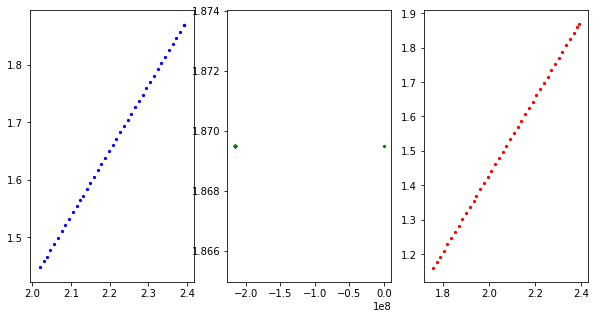

In [201]:
kinematics.plot_paths()

## Nuvem de pontos

In [175]:
class PointCloud():
    def __init__(self, robot, us_sensors, laser_sensor):
        self.robot = robot
        self.us_sensors = us_sensors
        self.laser_sensor = laser_sensor
        
        self.ultrassonic_points = []
        self.laser_points = []
        self.robot_points = []
    
    def update(self):
        #Insere posição atual do robo
        robot_x = self.robot.get_current_position()[0]
        robot_y = self.robot.get_current_position()[1]
        robot_ang = self.robot.get_current_orientation()[2]
        
        self.robot_points.append([robot_x,robot_y])

        #Atualiza a leitura do laser e insere na nuvem de pontos
        self.laser_sensor.update_robot_frame_reading()
        for pointx, pointy in zip(self.laser_sensor.laser_x, self.laser_sensor.laser_y):
            x,y = toGlobal(robot_x, robot_y,robot_ang, pointx, pointy)
            self.laser_points.append([x,y])

        #Atualiza a leitura do ultrassonico e insere na nuvem de pontos
        self.us_sensors.update_robot_frame_reading()
        for pointx, pointy in zip(self.us_sensors.data['robot_frame_reading'][:,0], self.us_sensors.data['robot_frame_reading'][:,1]):
            x,y = toGlobal(robot_x, robot_y,robot_ang, pointx, pointy)
            self.ultrassonic_points.append([x,y])
    
    def plot_point_cloud(self):
        #Convertendo a nuvem de pontos em um array
        ultrassonic_point_array = np.array(self.ultrassonic_points)
        laser_point_array = np.array(self.laser_points)
        robot_path = np.array(self.robot_points)

        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
        #posição do centro do robo
        ax[0].scatter(robot_path[:,0], robot_path[:,1], 40, c='b', marker='o')
        pass_count = 0
        for x, y in zip(robot_path[:,0], robot_path[:,1]):
            ax[0].text(x, y, str(pass_count), color="black", fontsize=12)
            pass_count += 1
        #posição dos pontos lidos pelo sensor ultrassonico
        ax[0].scatter(ultrassonic_point_array[:,0],ultrassonic_point_array[:,1], 10, c='magenta', marker='.')

        #posição do centro do robo
        ax[1].scatter(robot_path[:,0], robot_path[:,1], 40, c='b', marker='o')
        pass_count = 0
        for x, y in zip(robot_path[:,0], robot_path[:,1]):
            ax[1].text(x, y, str(pass_count), color="black", fontsize=12)
            pass_count += 1
        #posição dos pontos lidos pelo sensor laser
        ax[1].scatter(laser_point_array[:,0],laser_point_array[:,1], 10, c='r', marker='.')

        plt.show()
    
        

In [176]:
point_cloud = PointCloud(robot, us_sensors, laser_sensor)

In [180]:
#Passo 1
point_cloud.update()

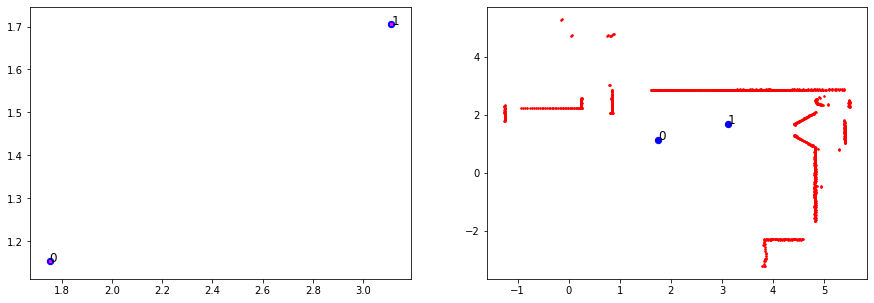

In [181]:
#Passo 2
point_cloud.plot_point_cloud()

In [179]:
#Passo 3

#Move o robo
robot.set_right_velocity(3)
robot.set_left_velocity(4)
time.sleep(10)
robot.stop()

Visto que estamos utilizando um Jupyter Notebook para apresentação do código, execute repetidas vezes os passos 1, 2 e 3, simulando o movimento do robo adquirindo informações.
Em uma situação real, os processos de coleta, movimento e odometria executariam em threads separadas.

# Juntando tudo

In [198]:
class MobileRobot():
    def __init__(self):
        self.robot = Robot()
        self.kinematicModel = Kinematic_model(self.robot)
        self.us_sensors = Us_sensor(robot)
        self.laser_sensors = Laser_sensor(robot)
        self.point_cloud = PointCloud(robot, self.us_sensors, self.laser_sensors)
        
        self.point_cloud.update()
    
        self.compute_interval = 0.5
        
        self.braitenbergL=[-0.2,-0.4,-0.6,-0.8,-1.0,-1.2,-1.4,-1.6]
        self.braitenbergR=[-1.6,-1.4,-1.2,-1.0,-0.8,-0.6,-0.4,-0.2]

        self.detect = [0,0,0,0,0,0,0,0]
        self.noDetectionDist = 1.0
        self.maxDetectionDist = 0.2
        
    def braitenberg(self, dist, vel):
        vLeft = vRight = vel
        for i in range(len(dist)):
            if(dist[i] < self.noDetectionDist):
                self.detect[i] = 1 - ((dist[i]-self.maxDetectionDist)/(self.noDetectionDist-self.maxDetectionDist))
            else:
                self.detect[i]=0
            for i in range(8):
                vLeft = vLeft + self.braitenbergL[i]*self.detect[i]
                vRight = vRight+ self.braitenbergR[i]*self.detect[i]
                
        return [vLeft, vRight]

    def start_braitenberg(self, seconds):
        for step in range(int(seconds/self.compute_interval)):
            Phi_l, Phi_r = self.braitenberg(self.us_sensors.data["raw_reading"][:8],2)
            self.kinematicModel.move(Phi_r, Phi_l,self.compute_interval)
            self.kinematicModel.plot_paths()
            self.point_cloud.update()
            self.point_cloud.plot_point_cloud()

In [199]:
mr = MobileRobot()

Connected to remoteApi server.
 Pioneer_p3dx_ultrasonicSensor1 connected.
 Pioneer_p3dx_ultrasonicSensor2 connected.
 Pioneer_p3dx_ultrasonicSensor3 connected.
 Pioneer_p3dx_ultrasonicSensor4 connected.
 Pioneer_p3dx_ultrasonicSensor5 connected.
 Pioneer_p3dx_ultrasonicSensor6 connected.
 Pioneer_p3dx_ultrasonicSensor7 connected.
 Pioneer_p3dx_ultrasonicSensor8 connected.
 Pioneer_p3dx_ultrasonicSensor9 connected.
 Pioneer_p3dx_ultrasonicSensor10 connected.
 Pioneer_p3dx_ultrasonicSensor11 connected.
 Pioneer_p3dx_ultrasonicSensor12 connected.
 Pioneer_p3dx_ultrasonicSensor13 connected.
 Pioneer_p3dx_ultrasonicSensor14 connected.
 Pioneer_p3dx_ultrasonicSensor15 connected.
 Pioneer_p3dx_ultrasonicSensor16 connected.
 Vision sensor connected.
 Laser connected.
 Left motor connected.
 Right motor connected.
 Robot connected.


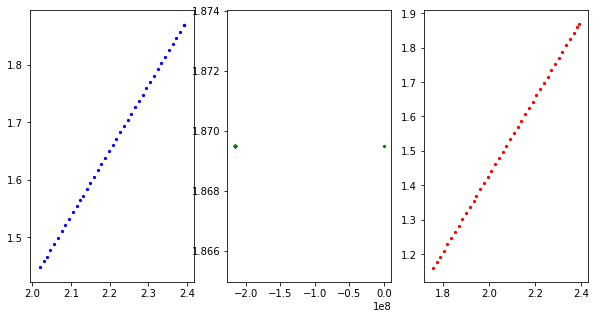

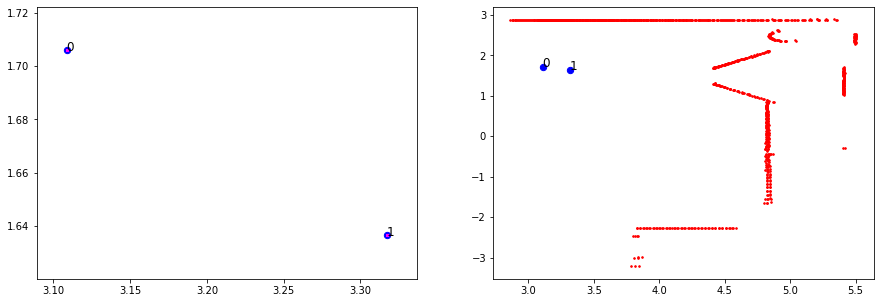

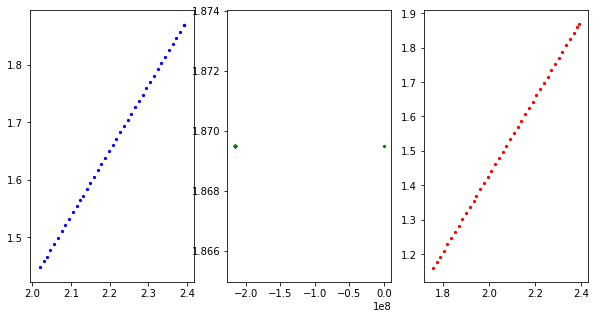

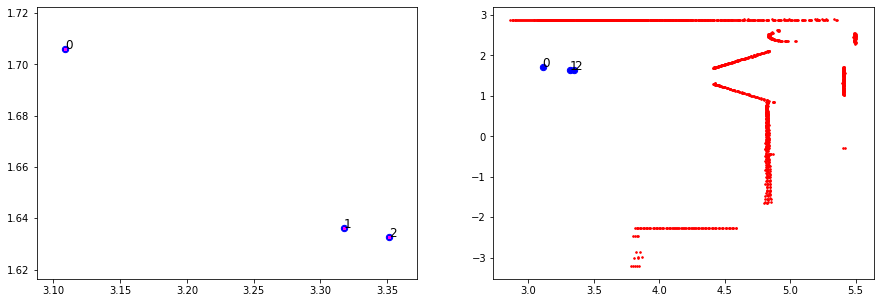

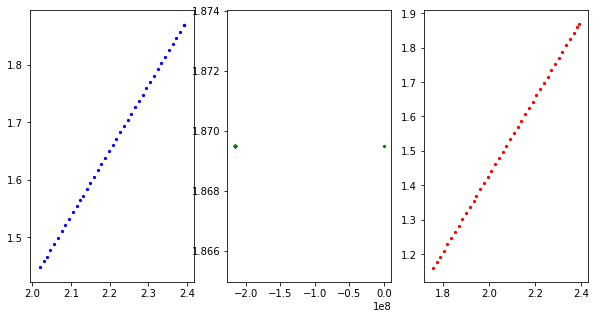

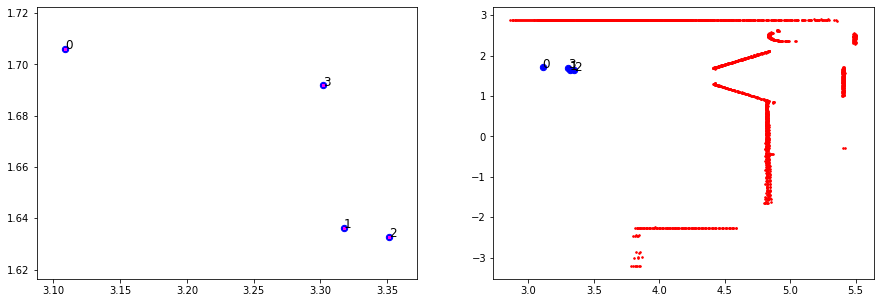

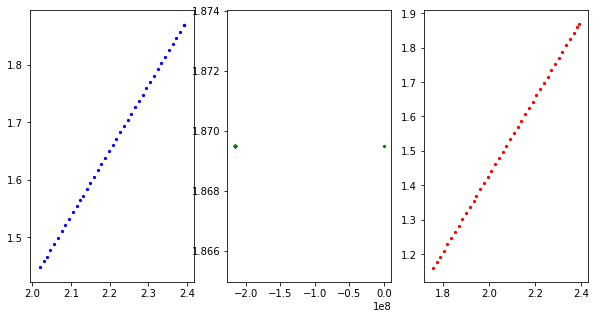

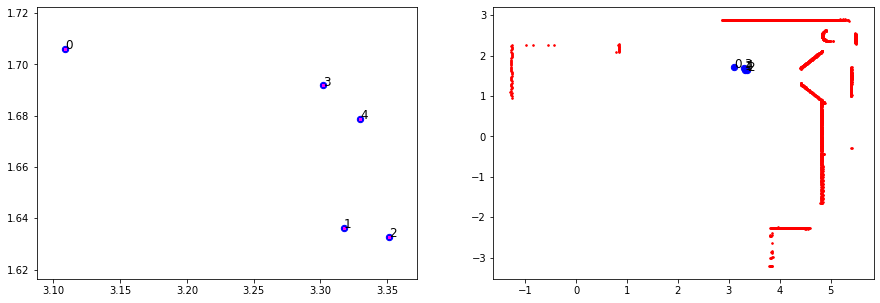

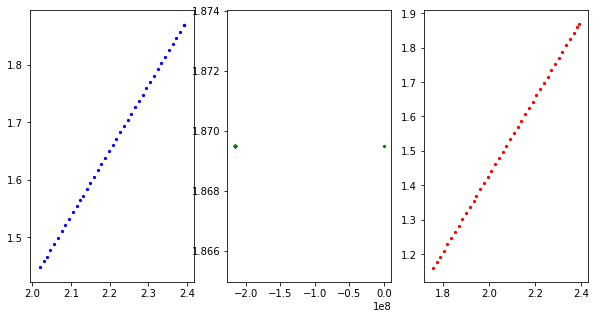

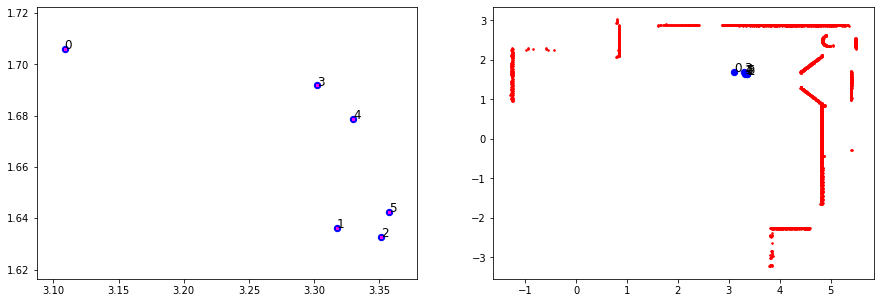

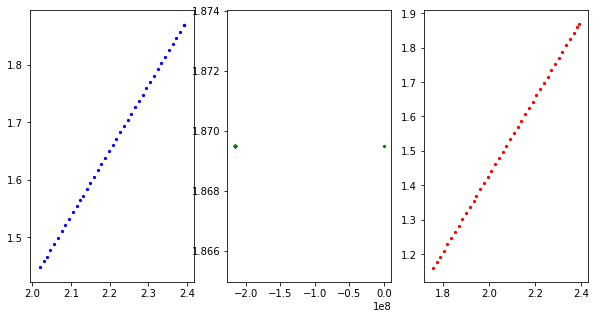

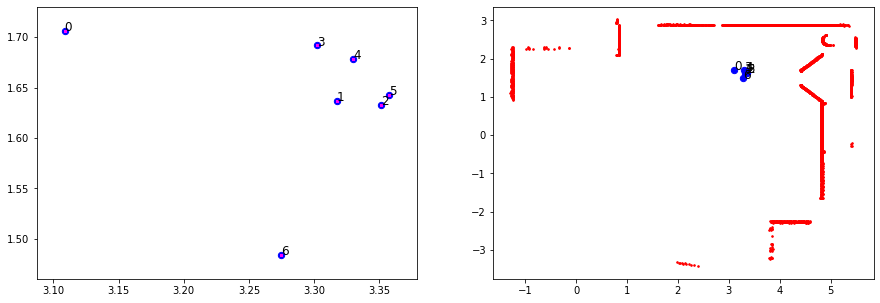

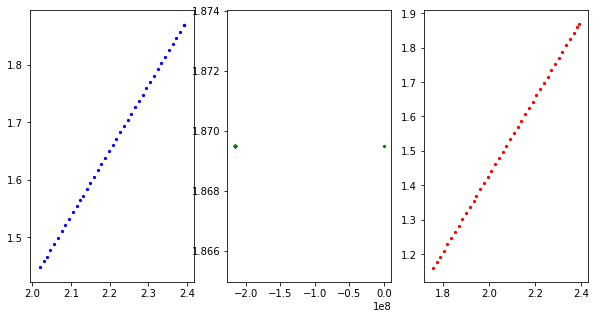

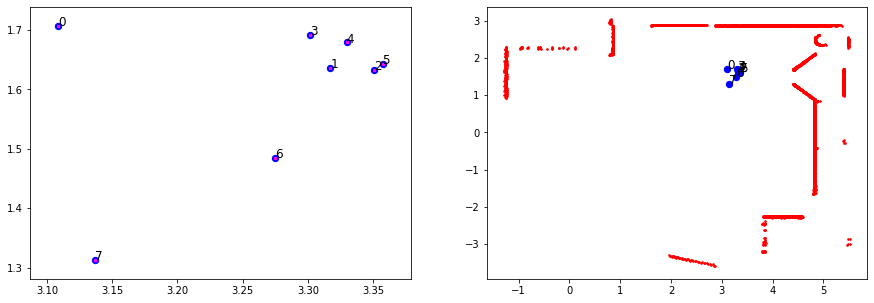

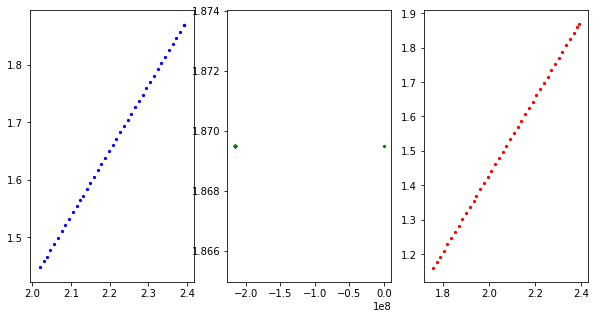

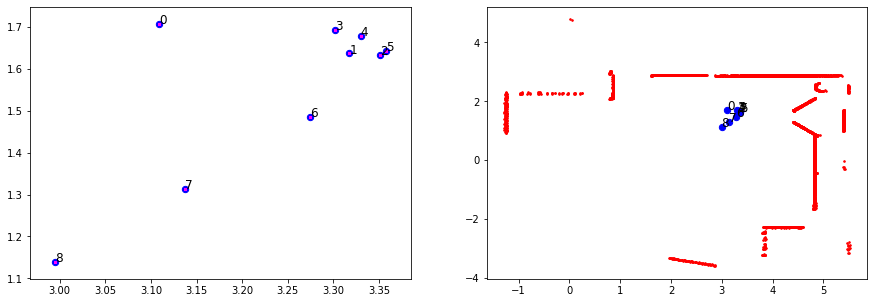

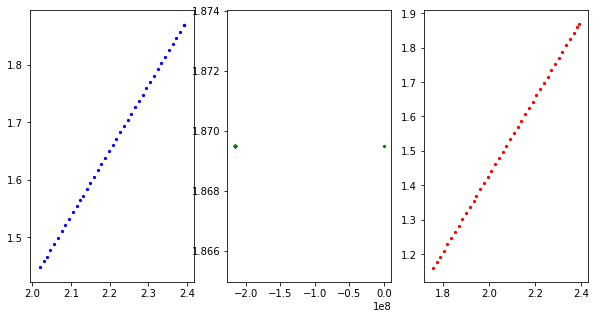

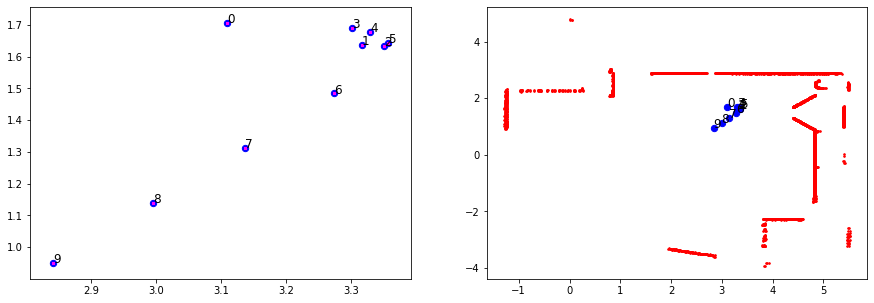

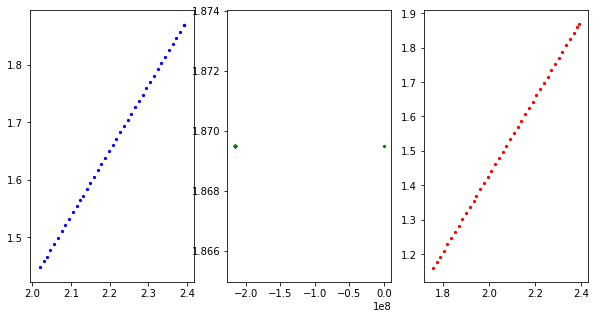

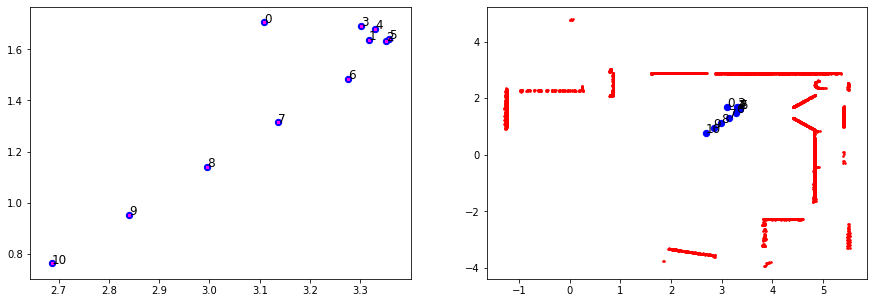

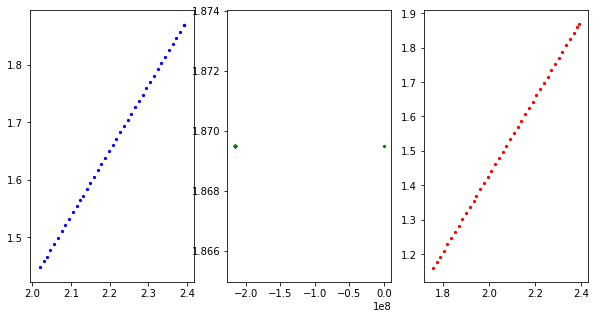

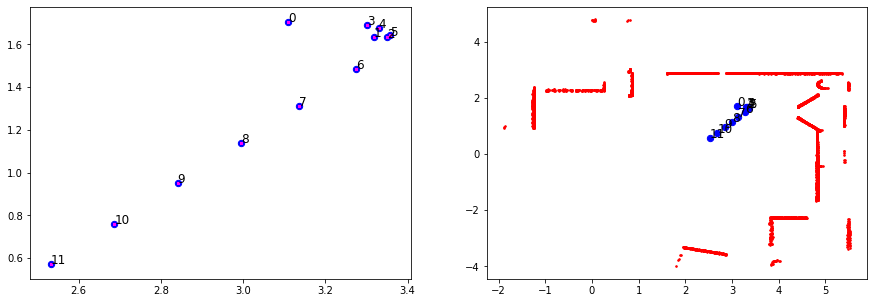

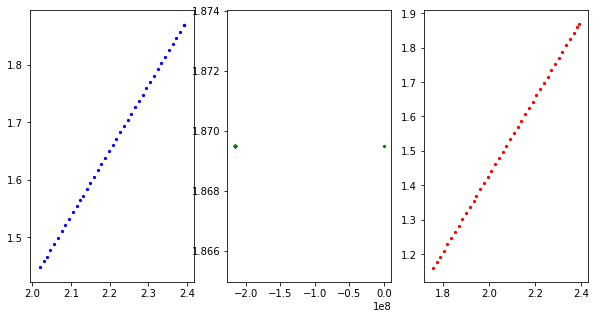

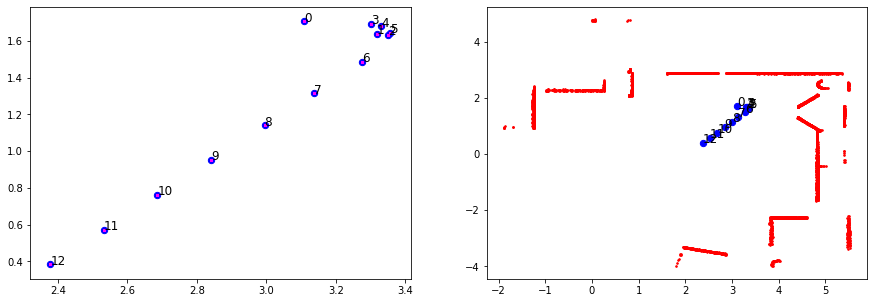

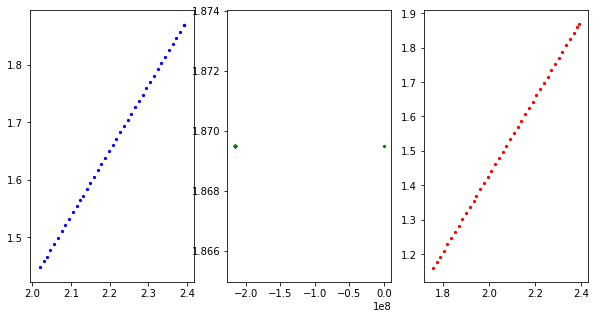

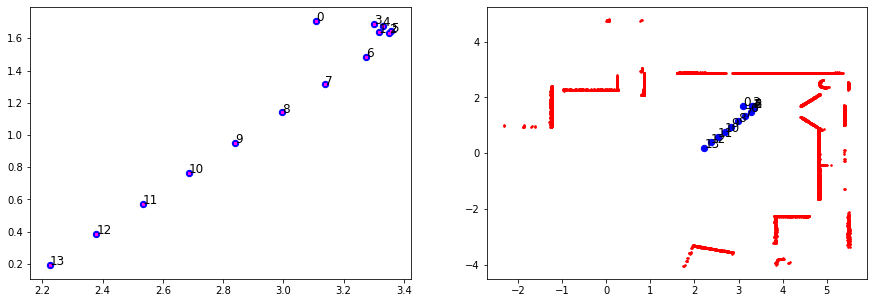

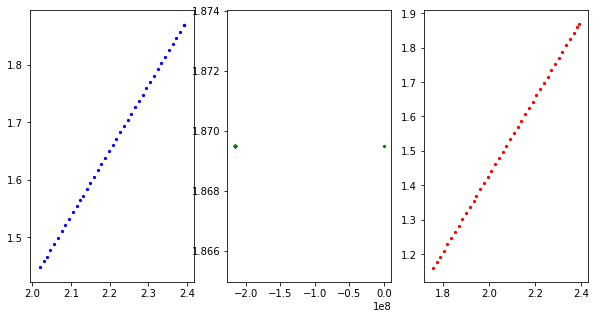

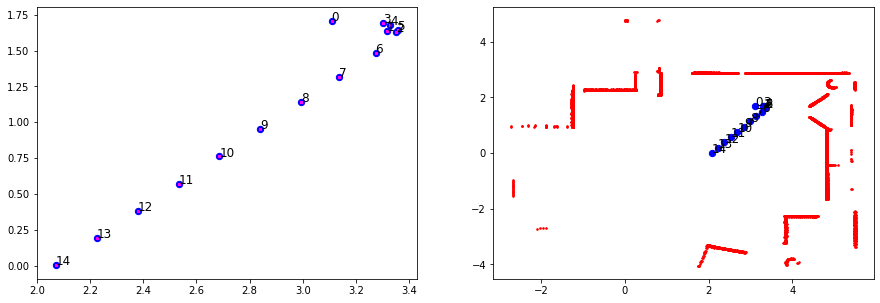

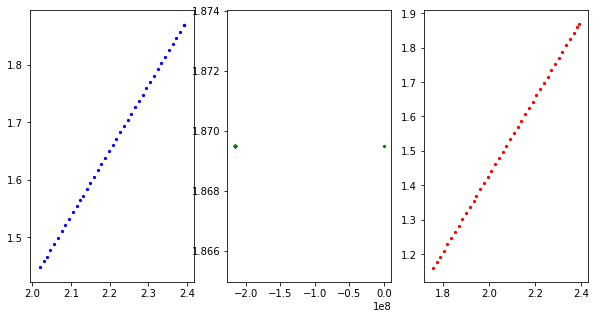

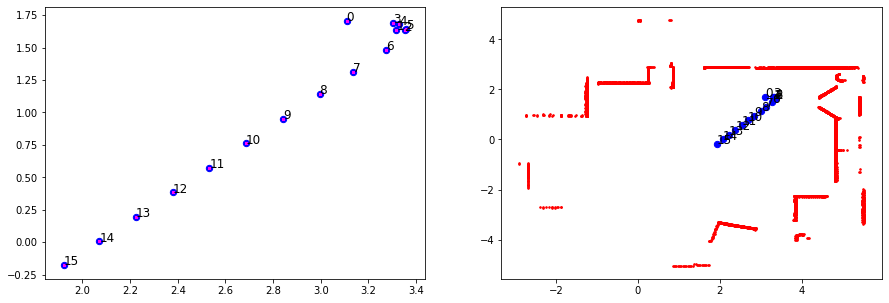

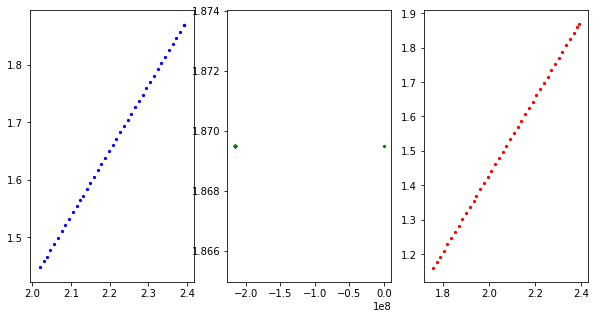

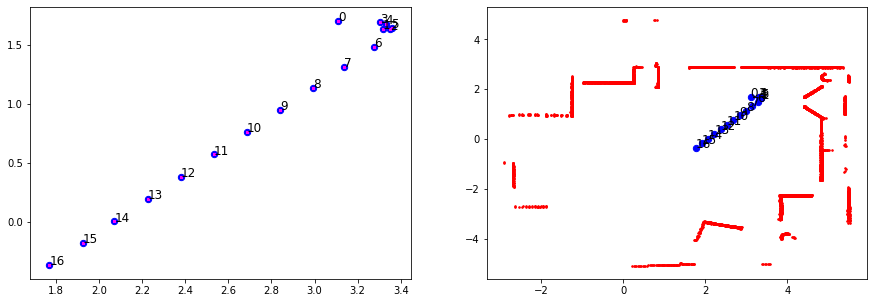

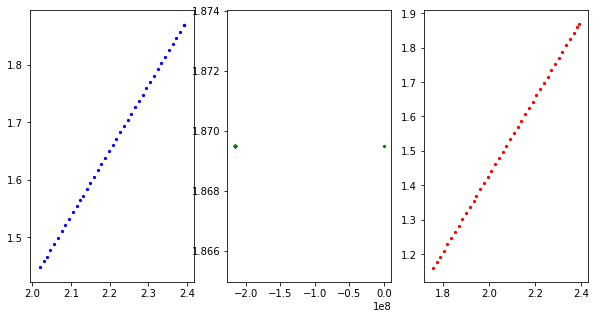

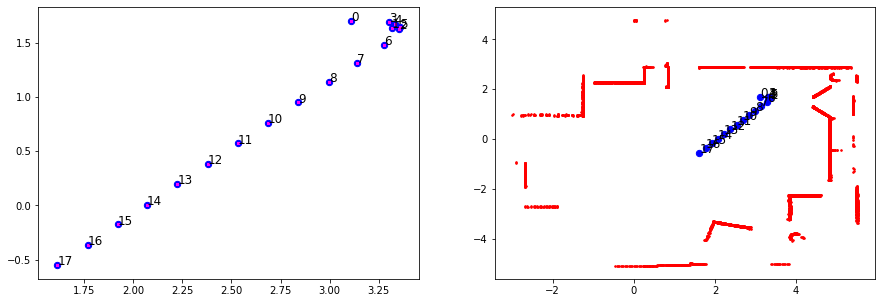

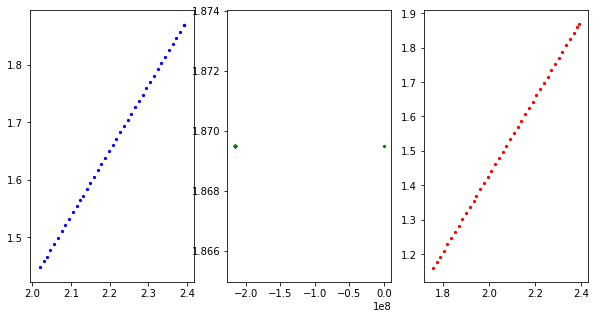

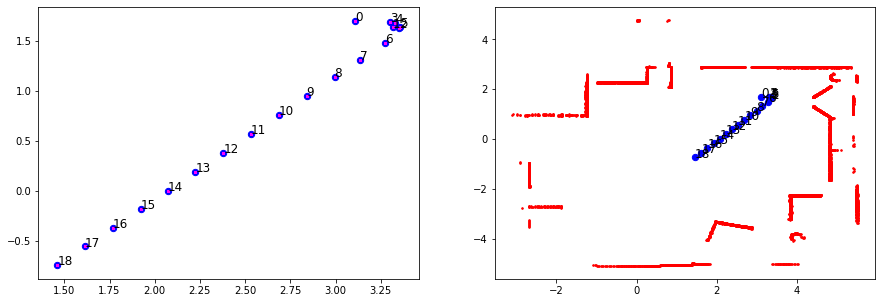

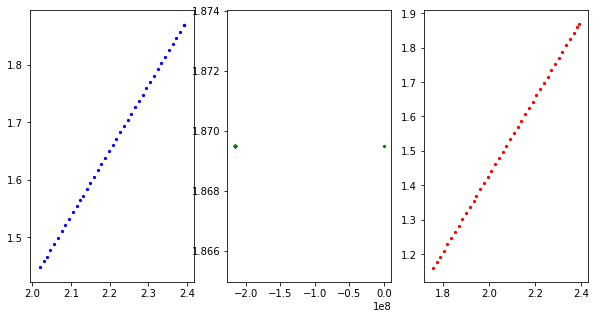

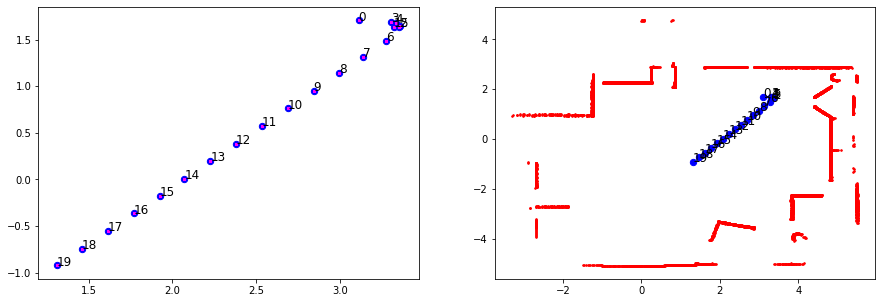

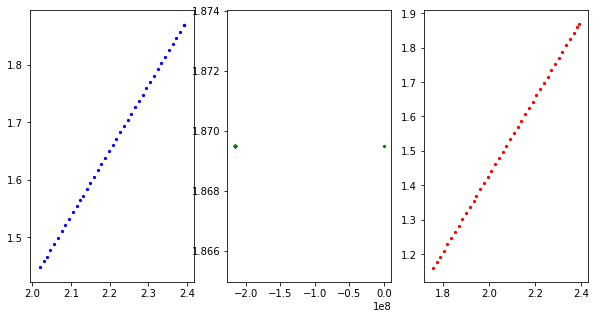

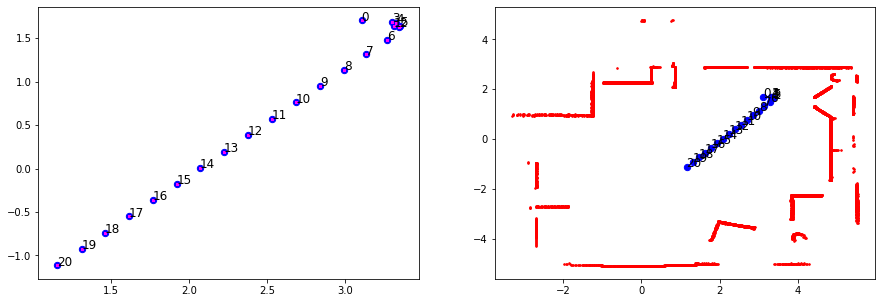

In [200]:
mr.start_braitenberg(10)